In [69]:
import ta
import numpy as np
import pandas as pd
import random

import warnings
# Turn off all warnings
warnings.filterwarnings("ignore")

In [70]:
import ccxt
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, MACD
import re
import random

# Fetch OHLCV data from Kraken
def fetch_ohlcv_data(start_date):
    exchange = ccxt.kraken()
    symbol = 'BTC/AUD'
    timeframe = '1d'
    since = exchange.parse8601(start_date)
    ohlcv_data = exchange.fetch_ohlcv(symbol, timeframe, since, limit=None)
    
    # Convert the data to a Pandas DataFrame and set column names
    ohlcv_df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'o', 'h', 'l', 'c', 'v'])
    # Convert the timestamp to a human-readable datetime format
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

    return ohlcv_df

ohlcv_data = fetch_ohlcv_data("2021-01-01T00:00:00Z")

print(ohlcv_data[:3])

   timestamp        o        h        l        c          v
0 2021-05-15  64381.4  65591.5  60400.0  60635.0  12.292069
1 2021-05-16  60772.4  64094.7  56733.2  60065.5  26.615730
2 2021-05-17  59974.1  60193.9  54452.0  55863.5  39.069198


In [71]:

def rsi(data, rsi_period = 14):
    if(f"rsi_{rsi_period}" in data.columns):
        return f"rsi_{rsi_period}"
    rsi_indicator = RSIIndicator(data['c'], window=rsi_period)
    rsi = rsi_indicator.rsi()
    data[f"rsi_{rsi_period}"] = rsi
    return f"rsi_{rsi_period}"

def sma(data,sma_period =20):
    if(f"sma_{sma_period}" in data.columns):
        return f"sma_{sma_period}"
    sma_indicator = SMAIndicator(data['c'], window=sma_period)
    sma = sma_indicator.sma_indicator()
    data[f"sma_{sma_period}"] = sma
    return f"sma_{sma_period}"

def macd(data,macd_fast =12,macd_slow =26,macd_signal = 9):
    if(f"macd_{macd_fast}_{macd_slow}_{macd_signal}" in data.columns):
        return f"macd_{macd_fast}_{macd_slow}_{macd_signal}"
    macd_indicator = MACD(ohlcv_data['c'],macd_fast, macd_slow, macd_signal)
    macd = macd_indicator.macd()  # MACD line
    data[f"macd_{macd_fast}_{macd_slow}_{macd_signal}"] = macd
    return f"macd_{macd_fast}_{macd_slow}_{macd_signal}"

def macd_signal(data,macd_fast =12,macd_slow =26,macd_signal = 9):
    if(f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}" in data.columns):
        return f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"
    macd_indicator = MACD(ohlcv_data['c'],macd_fast, macd_slow, macd_signal)
    macd_sig = macd_indicator.macd_signal()  # Signal line
    data[f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"] = macd_sig
    return f"macd_signal_{macd_fast}_{macd_slow}_{macd_signal}"

def constant(data,constant = 30):
    if(f"constant_{constant}" in data.columns):
        return f"constant_{constant}"
    data[f"constant_{constant}"] = constant
    return f"constant_{constant}"

def candle(data,candle ="o"):
    return candle




In [89]:


class Value():
    def __init__(self):
        values = [
            {
                "name":rsi,
                "parameters":[random.randint(14,28)],
            },
            {
                "name":sma,
                "parameters": [random.randint(20,40)],
            },
            {
                "name":macd,
                "parameters": random.choice([[12,26,9],[24,52,18]]),
            },
            {
                "name":macd_signal,
                "parameters": random.choice([[12,26,9],[24,52,18]]),
            },
            {   "name":constant, 
                "parameters":[random.randint(10,50)],
            },
            {
                "name":candle,
                "parameters":[random.choice(['o', 'h', 'l', 'c', 'v'])],
            }
        ]
        self.indicator = random.choice(values)
        self.column_name = self.indicator['name'](ohlcv_data, *self.indicator['parameters'])

    def evaluate(self,time):
        return f'ohlcv_data.{self.column_name}.iloc[{time}]'

    def __str__(self):
        return f'{self.column_name}'


class Literal():
    def __init__(self):
        self.negated = random.choice([True, False])
        self.value1 = Value()
        self.c = random.random()
        self.value2 = Value()

    def evaluate(self,time):
        if self.negated:
            return f'not ({self.value1.evaluate(time)} > {self.c} * {self.value2.evaluate(time)})'
        return f'({self.value1.evaluate(time)} > {self.c} * {self.value2.evaluate(time)})'

    def __str__(self):
        if self.negated:
            return f'not ({self.value1} > {self.c} * {self.value2})'
        return f'({self.value1} > {self.c} * {self.value2})'

class Conjugate():
    def __init__(self):
        self.literals = []
        self.generate_lit()

    def generate_lit(self):
        rand_num = random.random()
        if rand_num < 0.5:
            self.literals.append(Literal())
            self.generate_lit()
            return
        self.literals.append(Literal())
        return 
    
    def evaluate(self,time):
        out_str =""
        for literal in self.literals:
            out_str += f"({literal.evaluate(time)}) and "
        return out_str[:-4]

    def __str__(self):
        out_str =""
        for literal in self.literals:
            out_str += f"({literal.__str__()}) and "
        return out_str[:-4]
        
class Gene:
    def __init__(self) -> None:
        self.sell_conjugates = []
        self.buy_conjugates = []
        self.generate_buy_conjugates()
        self.generate_sell_conjugates()
    
    def generate_buy_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.5:
            self.buy_conjugates.append(Conjugate())
            self.generate_buy_conjugates()
            return
        self.buy_conjugates.append(Conjugate())
        return

    def generate_sell_conjugates(self):
        rand_num = random.random()
        if rand_num < 0.5:
            self.sell_conjugates.append(Conjugate())
            self.generate_sell_conjugates()
            return
        self.sell_conjugates.append(Conjugate())
        return

    def evaluate_buy(self,time):
        out_str =""
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-3])

    def evaluate_sell(self,time):
        out_str =""
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.evaluate(time)}) or "
        return eval(out_str[:-3])

    def __str__(self):
        out_str ="BUY CONDITIONS: "
        for conjugate in self.buy_conjugates:
            out_str += f"({conjugate.__str__()}) or "
        out_str = out_str[:-3]
        out_str += "\nSELL CONDITIONS: "
        for conjugate in self.sell_conjugates:
            out_str += f"({conjugate.__str__()}) or "
        out_str = out_str[:-3]
        return out_str

a = Gene()
print(a)
print(a.evaluate_buy(0))
print(a.evaluate_sell(0))


BUY CONDITIONS: ((not (constant_24 > 0.08529268811470903 * macd_12_26_9)) and ((l > 0.6007452206458214 * sma_23)) ) 
SELL CONDITIONS: ((not (macd_12_26_9 > 0.3788485620670571 * l)) ) 
((not (ohlcv_data.constant_24.iloc[0] > 0.08529268811470903 * ohlcv_data.macd_12_26_9.iloc[0])) and ((ohlcv_data.l.iloc[0] > 0.6007452206458214 * ohlcv_data.sma_23.iloc[0])) )  False
((not (ohlcv_data.macd_12_26_9.iloc[0] > 0.3788485620670571 * ohlcv_data.l.iloc[0])) )  True


In [100]:
def trading_bot(gene, ohlcv_data):
    n = len(ohlcv_data)
    positions = []
    bought = False

    fiat_money = 100
    btc_money = 0
    fee = 0.02 # Each buy or sell event costs 2% of current holdings.

    for t in range(1, n):
        close_price = ohlcv_data.loc[t, 'c']      

        if (gene.evaluate_buy(t)) and (not gene.evaluate_buy(t-1)) and (not bought) and (not gene.evaluate_sell(t) and not gene.evaluate_sell(t-1)):
            positions.append(('buy', t))
            btc_money = (fiat_money / close_price) * (1 - fee)
            fiat_money = 0
            bought = True
            
        elif (gene.evaluate_sell(t)) and (not gene.evaluate_sell(t-1)) and (bought) and (not gene.evaluate_buy(t) and not gene.evaluate_buy(t-1)):
            positions.append(('sell', t))
            fiat_money = (btc_money * close_price) * (1 - fee)
            btc_money = 0
            bought = False

    if bought:
        positions.append(('sell', n - 1))

    return positions, fiat_money, btc_money
    

a = Gene()
print(a)
print(trading_bot(a, ohlcv_data))

### This is where I got up to 
    

BUY CONDITIONS: ((not (macd_signal_12_26_9 > 0.8117936611433164 * l)) and (not (rsi_20 > 0.28616329678864005 * rsi_14)) and (not (constant_37 > 0.609169261110202 * constant_12)) ) or ((not (macd_12_26_9 > 0.7449362953698367 * constant_28)) ) 
SELL CONDITIONS: (((constant_15 > 0.44201211500986715 * constant_29)) and (not (constant_38 > 0.47715109159277147 * constant_26)) and (not (constant_50 > 0.6611219999257931 * sma_30)) and (not (c > 0.5780808315400728 * macd_12_26_9)) ) 
([], 100, 0)


In [9]:
import copy
import numpy as np
best_genome = None

class Genome:
    def __init__(self, fitness, genes):
        self.fitness = fitness
        self.genes = genes

class TrainGenomes():
	def __init__(self, population_size, generations, num_weights, num_b, ohlcv_data):
		self.population_size = population_size
		self.generations = generations
		self.num_weights = num_weights
		self.num_b = num_b
		self.ohlcv_data = ohlcv_data

	def train(self):
		global best_genome
		# Initialize the population

		no_improvement = 0
		mutation_rate = 0.05

		population = self.initialize_population(self.population_size, self.num_weights)
		# Evaluate the population
		for i in range(self.generations):
			population = self.evaluate_population(population)
			# Sort the population by fitness
			population.sort(key=lambda x: x.fitness, reverse=True)
			# # Keep track of the best genome
			#self.save_population(population,f"pre_genomes.csv")
			print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")

			if i > 0 and population[0].fitness == best_genome.fitness:
				no_improvement += 1
			else:
				no_improvement = 0
			# Update the mutation rate
			if no_improvement > 5:
				mutation_rate *= 1.1
			else:
				mutation_rate = 0.05

			best_genome = population[0]
			# Seperate elite from population
			# do tournament selection for next generation
			population = self.tournament_selection(population, 0.05, 2, mutation_rate)
			# # Add the elite to the population
			# population.extend(elite)
			population.sort(key=lambda x: x.fitness, reverse=True)
			#self.save_population(population,f"post_genomes.csv")
	    
	def save_population(self,population,name):
		#save list of population classes as csv
		lst = [x.__dict__ for x in population]
		pd.DataFrame(lst).to_csv(f"{name}.csv")

	def initialize_population(self, population_size, num_weights):
		population = []
		for i in range(population_size):
			genes = np.random.uniform(0, 1, num_weights)
			population.append(Genome(0, genes))
		return population
	
	def evaluate_population(self, population):
		for genome in population:
			genome.fitness = self.fitness(genome)
		return population
	
	def fitness(self, genome):

		P = [30, 70]  # Define the set of parameters for the bot (buy RSI threshold, sell RSI threshold)
		buy_weights = genome.genes[:self.num_b] ## Split the genome between the buy and sell weights, num_b is the number of buy weights
		sell_weights = genome.genes[self.num_b:]
		positions, fiat_money, btc_money = trading_bot(P, ohlcv_data, buy_gene, sell_gene, buy_weights, sell_weights)
		return fiat_money + (btc_money * ohlcv_data.iloc[-1]['c'])	
	
	def tournament_selection(self, population, elitism, tournament_size, mutation_rate):
        # Select elite
		elite = population[:int(elitism * len(population))]
        # Initialize an empty list for the parents
		parents = []
		for _ in range(len(population) - len(elite)):
            # Randomly select tournament_size genomes
			tournament = np.random.choice(population, size=tournament_size)
            # Select the best genome
			winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
            # Apply mutation to winner.genes
			for i in range(winner.genes.size):
				mutation = np.random.uniform(-mutation_rate, mutation_rate)
				winner.genes[i] = max(0, winner.genes[i] + mutation)
            # Add the winner to the parents list
			parents.append(winner)

        # Add the elite to the parents list
		parents.extend(elite)
		return parents


In [10]:
import random

buy_gene = Gene()
sell_gene = Gene()

print(buy_gene)
print(sell_gene)

num_weights=count_c(str(buy_gene))+count_c(str(sell_gene))
num_b = count_c(str(buy_gene))
num_s = count_c(str(sell_gene))

train_genomes = TrainGenomes(population_size=100, generations=3, num_weights=num_weights, num_b=num_b, ohlcv_data=ohlcv_data)

train_genomes.train()
print("Best genome:", best_genome.genes)
print("Best genome fitness:", best_genome.fitness)


((not (o(t) > c * sma)) and ((not (o(t) > c * sma)) and (macd > c * masignal)))
(((not (o(t) > c * sma)) and ((not (o(t) > c * sma)) and (macd > c * masignal))) or (not (rsi > c * rsthreshold)))
Generation 0 best genome fitness: 100.0, average fitness: 100.0
Generation 1 best genome fitness: 100.0, average fitness: 100.0
Generation 2 best genome fitness: 100.0, average fitness: 100.0
Best genome: [0.51694238 0.26026538 0.75050649 0.39382556 0.43811108 0.18158002
 0.18209332]
Best genome fitness: 100.0


[('buy', 401), ('sell', 719)]
142.1456547518211


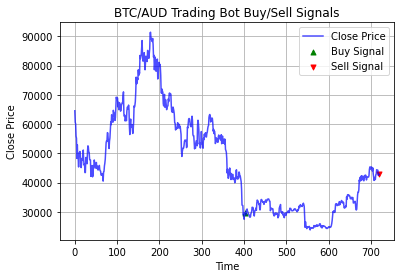

In [94]:
positions, fiat_money, btc_money = trading_bot(P, ohlcv_data, buy_gene, sell_gene, best_genome.genes[:num_b], best_genome.genes[num_b:])
print(positions)
print(fiat_money + (btc_money * ohlcv_data.iloc[-1]['c']))
import matplotlib.pyplot as plt

# Extract the timestamps, close prices, and buy/sell signals
timestamps = ohlcv_data.index
close_prices = ohlcv_data['c']
buy_signals = [t for action, t in positions if action == 'buy']
sell_signals = [t for action, t in positions if action == 'sell']

# Plot the price data
plt.plot(timestamps, close_prices, label='Close Price', color='blue', alpha=0.7)

# Plot the buy signals
plt.scatter([timestamps[t] for t in buy_signals],
            [close_prices[t] for t in buy_signals],
            color='g', s=25, marker="^", label='Buy Signal')

# Plot the sell signals
plt.scatter([timestamps[t] for t in sell_signals],
            [close_prices[t] for t in sell_signals],
            color='r', s=25, marker="v", label='Sell Signal')

# Customize the plot appearance

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('BTC/AUD Trading Bot Buy/Sell Signals')
plt.legend()
plt.grid()

# Show the plot
plt.show()